In [18]:
import pandas as pd
ratings = pd.read_csv('data/u.data', sep='\t',
names=['user_id', 'movie_id', 'rating', 'unix_timestamp'])


movies = pd.read_csv('data/u.item', sep='|',
usecols=range(2), names=['movie_id', 'title'],
encoding='latin-1')


ratings = ratings[ratings.rating >= 4]



from collections import defaultdict

pairs = defaultdict(int)

# Loop through the entire list of users
for group in ratings.groupby("user_id"):
    # List of IDs of movies rated by the current user
    user_movies = list(group[1]["movie_id"])

    # Count every time two movies are seen together
    for i in range(len(user_movies)):
        for j in range(i+1, len(user_movies)):
            pairs[(user_movies[i], user_movies[j])] += 1
            
            
import networkx as nx
# Create a networkx graph
G = nx.Graph()

# Try to create an edge between movies that are liked together
for pair in pairs:
    movie1, movie2 = pair
    score = pairs[pair]

    # The edge is only created when the score is high enough
    if score >= 20:
        G.add_edge(movie1, movie2, weight=score)

print("Total number of graph nodes:", G.number_of_nodes())
print("Total number of graph edges:", G.number_of_edges())



from node2vec import Node2Vec

node2vec = Node2Vec(G, dimensions=64, walk_length=20, num_walks=200, p=2, q=1, workers=1)

model = node2vec.fit(window=10, min_count=1, batch_words=4)


def recommend(movie):
    movie_id = str(movies[movies.title == movie].movie_id.values[0])
    for id in model.wv.most_similar(movie_id)[:5]:
        title = movies[movies.movie_id == int(id[0])].title.values[0]
        print(f'{title}: {id[1]:.2f}')

recommend('Star Wars (1977)')

Total number of graph nodes: 410
Total number of graph edges: 14936


Computing transition probabilities:   0%|          | 0/410 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 200/200 [00:13<00:00, 14.43it/s]


Raiders of the Lost Ark (1981): 0.58
Return of the Jedi (1983): 0.56
Toy Story (1995): 0.54
Monty Python and the Holy Grail (1974): 0.48
Godfather, The (1972): 0.43


In [20]:
import pandas as pd
import networkx as nx
from collections import defaultdict
from node2vec import Node2Vec
import pickle

def load_data():
    """
    Load user ratings and movie titles.
    """
    ratings = pd.read_csv('data/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'unix_timestamp'])
    movies = pd.read_csv('data/u.item', sep='|', usecols=range(2), names=['movie_id', 'title'], encoding='latin-1')
    return ratings, movies

def filter_ratings(ratings):
    """
    Filter ratings to keep only those 4 or above.
    """
    return ratings[ratings.rating >= 4]

def create_pairs(ratings):
    """
    Create pairs of movies that are liked together.
    """
    pairs = defaultdict(int)
    for group in ratings.groupby("user_id"):
        user_movies = list(group[1]["movie_id"])
        for i in range(len(user_movies)):
            for j in range(i+1, len(user_movies)):
                pairs[(user_movies[i], user_movies[j])] += 1
    return pairs

def build_graph(pairs):
    """
    Build a graph with movies as nodes and edges between frequently liked movies.
    """
    G = nx.Graph()
    for pair, score in pairs.items():
        if score >= 20:  # Threshold for creating an edge
            G.add_edge(pair[0], pair[1], weight=score)
    return G

def train_node2vec(G):
    """
    Train a Node2Vec model on the movie graph.
    """
    node2vec = Node2Vec(G, dimensions=64, walk_length=20, num_walks=200, p=2, q=1, workers=1)
    return node2vec.fit(window=10, min_count=1, batch_words=4)



# Function to save the model
def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)


def recommend(model, movies, movie_title):
    """
    Recommend movies similar to the given movie title.
    """
    try:
        movie_id = str(movies[movies.title == movie_title].movie_id.values[0])
        similar_movies = model.wv.most_similar(movie_id, topn=5)
        for id, score in similar_movies:
            title = movies[movies.movie_id == int(id)].title.values[0]
            print(f'{title}: {score:.2f}')
    except IndexError:
        print("Movie not found in dataset.")

# Main execution
ratings, movies = load_data()
ratings = filter_ratings(ratings)
pairs = create_pairs(ratings)
G = build_graph(pairs)
model = train_node2vec(G)
# Save the Node2Vec model
save_model(model, 'node2vec_movie_recommender.pkl')

Computing transition probabilities:   0%|          | 0/410 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 200/200 [00:13<00:00, 14.62it/s]


Raiders of the Lost Ark (1981): 0.65
Return of the Jedi (1983): 0.58
Toy Story (1995): 0.51
Monty Python and the Holy Grail (1974): 0.47
Fugitive, The (1993): 0.47


In [21]:
# Function to load the model
def load_model(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

# Load the Node2Vec model
model = load_model('node2vec_movie_recommender.pkl')

# Example recommendation
recommend(model, movies, 'Star Wars (1977)')

In [45]:
pip install scikit-learn

  Using cached scikit_learn-1.3.2-cp311-cp311-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached threadpoolctl-3.2.0-py3-none-any.whl.metadata (10.0 kB)
Using cached scikit_learn-1.3.2-cp311-cp311-macosx_12_0_arm64.whl (9.4 MB)
Using cached threadpoolctl-3.2.0-py3-none-any.whl (15 kB)
Note: you may need to restart the kernel to use updated packages.


In [48]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_embeddings(model):
    # Convert model.wv.vectors to a 2D array using PCA
    pca = PCA(n_components=2)
    result = pca.fit_transform(model.wv.vectors)

    # Create a scatter plot of the projection
    plt.figure(figsize=(10, 10))
    plt.scatter(result[:, 0], result[:, 1])
    plt.title("Node2Vec Embeddings Visualized with PCA")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

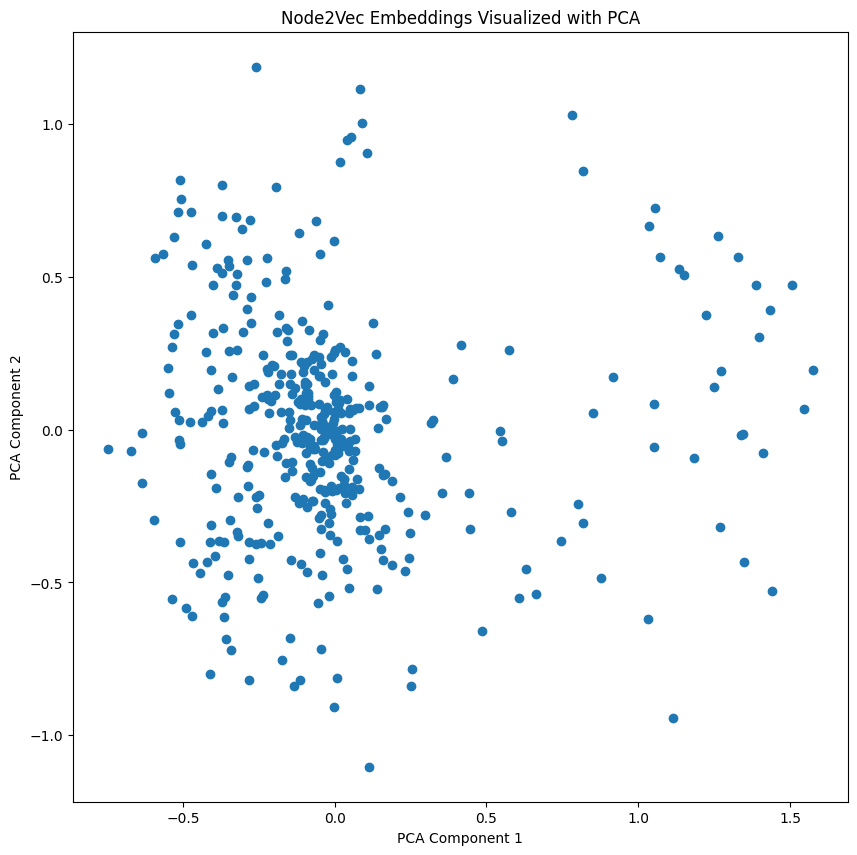

In [49]:
plot_embeddings(model)

In [50]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.
